In [3]:
# !pip install fastai

<A HREF="https://docs.fast.ai/">FastAI Docs</A><BR>
    <A HREF="https://docs.fast.ai/tutorial.vision">Computer Vision Tutorial</A><BR>

Following this blog post about <A HREF="https://walkwithfastai.com/Object_Detection">object detection using FastAI</A>

In [4]:
import pandas as pd
import numpy as np
from fastai.vision.all import *
from pathlib import Path # for making our own Path object
from wwf.vision.object_detection import * # walkwithfastai - for model

In [5]:
# path is a pathlib Path object, create it with Path()
path = Path('./') 
path

Path('.')

In [34]:
trainfiles = get_image_files(path/'train') # = './train' in pathlib Path object world
testfiles = get_image_files(path/'test')

In [35]:
len(trainfiles)

638

In [36]:
# this assumes object bounding boxes are stored in coco json format, not VOC xml format
# can use https://github.com/shiyemin/voc2coco to convert xml files to json
# need to change fn get_filename_as_int() (line 37) since our file names are not integers
imgs, lbl_bbox = get_annotations(path/'train/train.json')

In [37]:
imgs[0]

'42.634614_2.8724463.png'

In [38]:
lbl_bbox[0]

([[278, 82, 334, 136], [217, 213, 275, 271]], ['pool', 'pool'])

In [39]:
# may help with showing boxes, but then again maybe not so will comment it out
# lbl_bbox = [list(bbox) for bbox in lbl_bbox]

In [40]:
img2bbox = dict(zip(imgs, lbl_bbox))

In [41]:
first = {k: img2bbox[k] for k in list(img2bbox)[:1]}; first

{'42.634614_2.8724463.png': [[[278, 82, 334, 136], [217, 213, 275, 271]],
  ['pool', 'pool']]}

In [42]:
getters = [lambda o: path/'train'/o, lambda o: img2bbox[o][0], lambda o: img2bbox[o][1]]

In [43]:
# Transforms
item_tfms = [Resize(128, method='pad'),]
batch_tfms = [Rotate(), Flip(), Dihedral(), Normalize.from_stats(*imagenet_stats)]

In [44]:
def get_train_imgs(noop):  return imgs

In [45]:
pascal = DataBlock(blocks=(ImageBlock, BBoxBlock, BBoxLblBlock),
                 splitter=RandomSplitter(),
                 get_items=get_train_imgs,
                 getters=getters,
                 item_tfms=item_tfms,
                 batch_tfms=batch_tfms,
                 n_inp=1)

In [46]:
# put data in a DataLoaders object, there is more than one way to do this
# see https://docs.fast.ai/vision.data.html#ImageDataLoaders
#dls = pascal.dataloaders(path)
dls = ImageDataLoaders.from_folder('./train/')

In [47]:
dls.c = 20

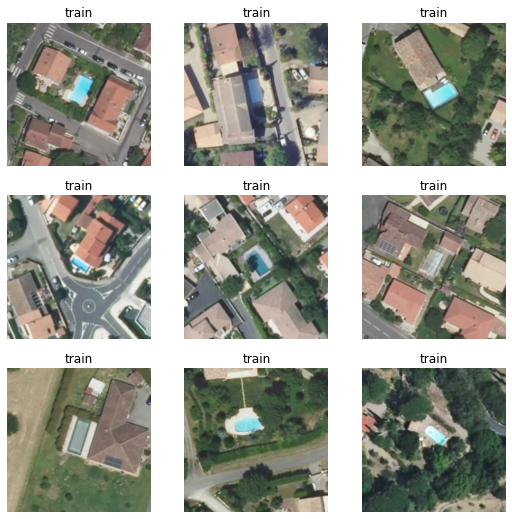

In [48]:
dls.show_batch()
# Hmmm no boxes, whats up?

# The Model

In [49]:
encoder = create_body(resnet34, pretrained=True)

In [50]:
get_c(dls)

20

In [51]:
arch = RetinaNet(encoder, get_c(dls), final_bias=-4)

In [52]:
create_head(124, 4)

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten(full=False)
  (2): BatchNorm1d(248, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=248, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=4, bias=False)
)

In [53]:
arch.smoothers

ModuleList(
  (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [54]:
arch.classifier

Sequential(
  (0): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (1): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (2): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (3): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (4): Conv2d(256, 180, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [55]:
arch.box_regressor

Sequential(
  (0): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (1): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (2): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (3): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (4): Conv2d(256, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [56]:
ratios = [1/2,1,2]
scales = [1,2**(-1/3), 2**(-2/3)]

In [57]:
crit = RetinaNetFocalLoss(scales=scales, ratios=ratios)

In [58]:
def _retinanet_split(m): 
    return L(m.encoder,nn.Sequential(m.c5top6, m.p6top7, m.merges, 
                                     m.smoothers, m.classifier, m.box_regressor)).map(params)

In [59]:
learn = Learner(dls, arch, loss_func=crit, splitter=_retinanet_split)

In [60]:
learn.freeze()

In [ ]:
# Now train!

In [ ]:
# This is computationally expensive and thus slow and locked up my computer!!!!
learn.fit_one_cycle(10, slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,time
